In [1]:
############
##  import libs and load data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from math import radians, degrees, sin, cos, asin, acos, sqrt
from mpl_toolkits.basemap import Basemap

df = pd.read_pickle("./data/dataframe3.pkl")

In [2]:
############
##  1) divide US and rest of the world (RDW)

#df_us = pd.DataFrame(df[df.countrycode == "US"])
#df_rdw = pd.DataFrame(df[df.countrycode != "US"])
df_us = df[df.countrycode == "US"].copy()
df_rdw = df[df.countrycode != "US"].copy()

In [3]:
############
##  2) recluster US and RDW

def great_circle(p1, p2):
    lat1 = p1[0]
    lon1 = p1[1]
    lat2 = p2[0]
    lon2 = p2[1]
    if (lat1==lat2 and lon1==lon2):
        return 0
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))

def cluster_dataset(cluster_mod, dataset):
    dataset["cluster"] = cluster_mod.fit_predict(pd.DataFrame(dataset,columns=['latitude','longitude']))
    return dataset
    
#############
# recluster US

us_cluster_model = DBSCAN(eps=200, min_samples=5, metric=great_circle)
df_us = cluster_dataset(us_cluster_model, df_us)

#############
# recluster RDW

rdw_cluster_model = DBSCAN(eps=900, min_samples=4, metric=great_circle)
df_rdw = cluster_dataset(rdw_cluster_model, df_rdw)

def add_clusterStats(dataset):
    cluster_data = []
    for i, cluster in dataset.groupby(["cluster"]):
        if i >= 0:
            cl_c_lat = dataset["latitude"][dataset.cluster == i].mean()
            cl_c_long = dataset["longitude"][dataset.cluster == i].mean()

            cluster_data.append({"cluster":i, 
                                 "cluster_size": cluster.headline.size, 
                                 "cluster_center": [cl_c_lat, cl_c_long]
                                })
    dataset = pd.merge(dataset, pd.DataFrame(cluster_data), on='cluster')
    return dataset

 
############
## add special cluster data (cluster_center, cluster_size)
df_us = add_clusterStats(df_us)
df_rdw = add_clusterStats(df_rdw)



In [4]:
############### 3) Sort the clusters by the number of headlines from largest to smallest.
#### 3 & 4 #### Sort headlines within each cluster by finding headlines closest to the center of the cluster.
###############

def add_clusterDist(dataset, newCol="dist2center"):
    dataset[newCol] = [great_circle([x[2], x[3]],x[7]) for x in dataset.values]
    return dataset

def sort_cluster(dataset):
    return dataset.sort_values(by=["cluster_size","dist2center"], ascending=[False, True]).groupby(["cluster"])

df_us = add_clusterDist(df_us)
df_rdw = add_clusterDist(df_rdw)

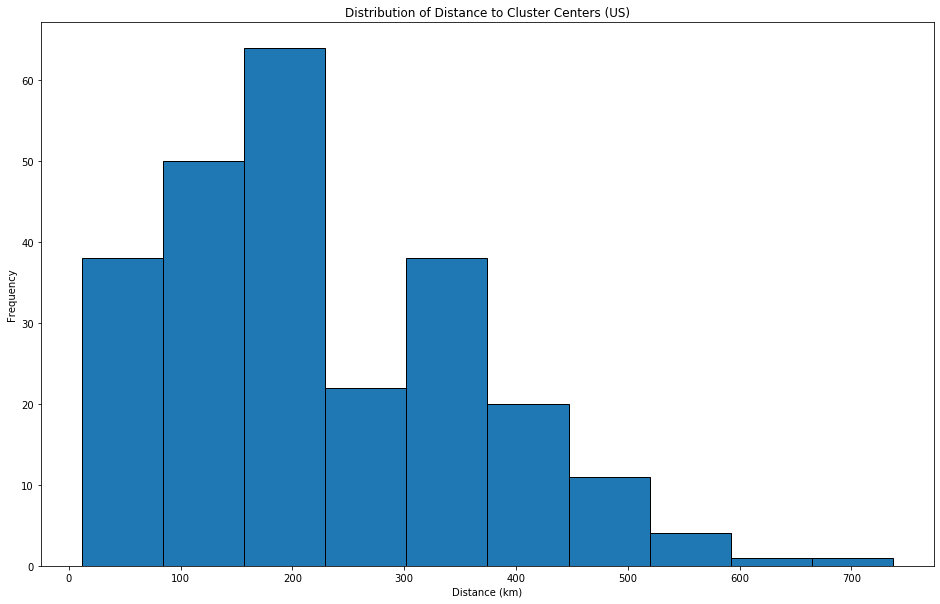

In [5]:
_ = df_us["dist2center"].plot.hist(
    title="Distribution of Distance to Cluster Centers (US)", figsize=(16, 10), edgecolor='k',
)
plt.xlabel('Distance (km)');

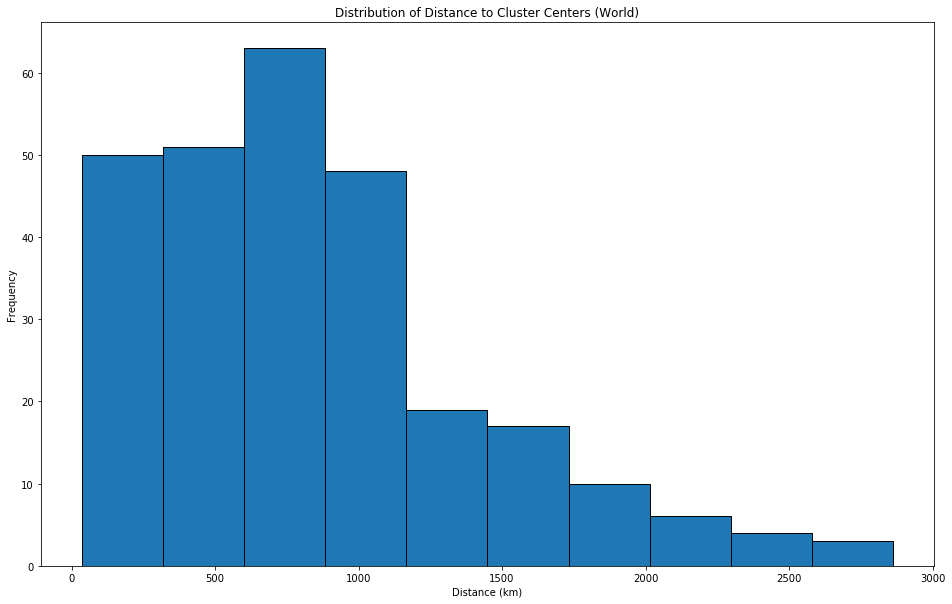

In [6]:
_ = df_rdw["dist2center"].plot.hist(
    title="Distribution of Distance to Cluster Centers (World)", figsize=(16, 10), edgecolor='k',
)
plt.xlabel('Distance (km)');

In [7]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 20

# %#matplotlib inline

# Map of US
us_map = Basemap(
    llcrnrlon=-119,
    llcrnrlat=22,
    urcrnrlon=-64,
    urcrnrlat=49,
    projection="lcc",
    lat_1=33,
    lat_2=45,
    lon_0=-95,
)

rdw_map = Basemap(projection='cyl')

def plotCluster(data, us=False, diseaseNames=None, countSize=False, plotTitle=""):
    plt.figure(figsize=(20, 14))
    plt.rcParams["font.size"] = 24

    if (us == True): # Read in states and draw map
        us_map.readshapefile("st99_d00", "states")
        us_map.shadedrelief()
    else:
        rdw_map.shadedrelief()
        #rdw_map.drawcoastlines()
        #rdw_map.drawcountries()

    # Iterate through each cluster and plot
    for i, cluster in data:

        # get size of cluster (from dataset (default) or calculated)
        cluster_size = 0
        if (countSize == False):
            cluster_size = int(cluster.cluster_size.mean())
        else:
            cluster_size = f"{cluster.headline.count()}/{int(cluster.cluster_size.mean())}"
        
        # adjust labels
        if (diseaseNames):
            label = f"Cluster: {i} - {diseaseNames[i]} ({cluster_size})"
        else:
            label = f"Cluster: {i} ({cluster_size})"

        # Plot the data points as a scatter plot colored by the cluster membership
        if (us == True):
            plt.scatter(
                cluster["x"],
                cluster["y"],
                s=80,
                alpha=1,
                marker="o",
                label=label,
                color=plt.cm.tab20(i+1),
            )
        else:
            rdw_map.scatter(cluster["longitude"], cluster["latitude"], latlon=True, s=80, label=label, color=plt.cm.tab20(i+1))

        center = [0,0]
        if (us == True):
            center[1], center[0] = us_map(x=list(cluster["cluster_center"].head(1))[0][1], y=list(cluster["cluster_center"].head(1))[0][0])
        else:    
            center = list(cluster["cluster_center"].head(1))[0]

        # Plot the cluster centers
        plt.scatter(
            center[1], 
            center[0], 
            #latlon=True, 
            marker='*', 
            s=300, 
            color=plt.cm.tab20(i+1)
        )

    # Add a legend and title
    ax = plt.gca()
    ax.legend(loc=(1, 0))
    _ = ax.set_title(plotTitle)


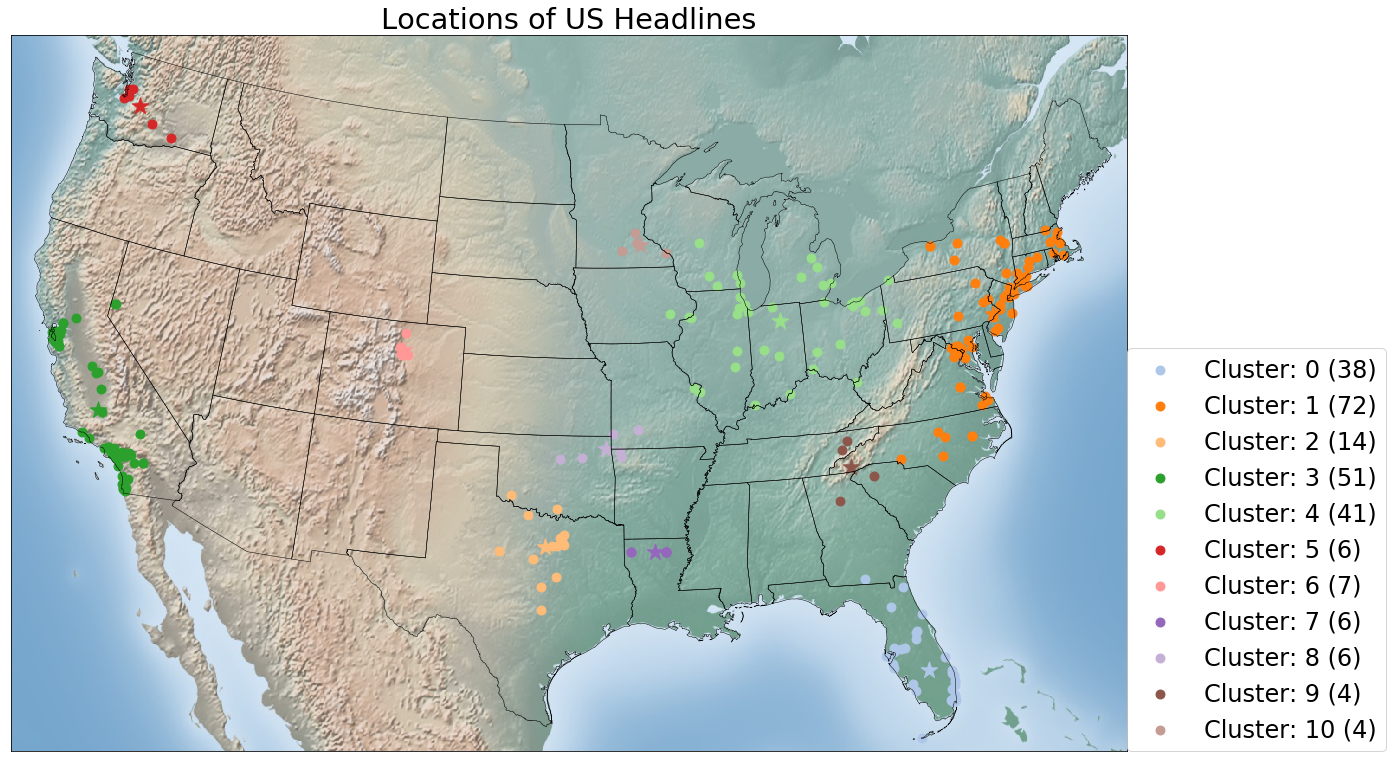

In [8]:
# Convert to map coordinates
df_us["x"], df_us["y"] = us_map(x=list(df_us["longitude"]), y=list(df_us["latitude"]))
df_us_sorted = sort_cluster(df_us)

plotCluster(df_us_sorted, True, plotTitle="Locations of US Headlines")

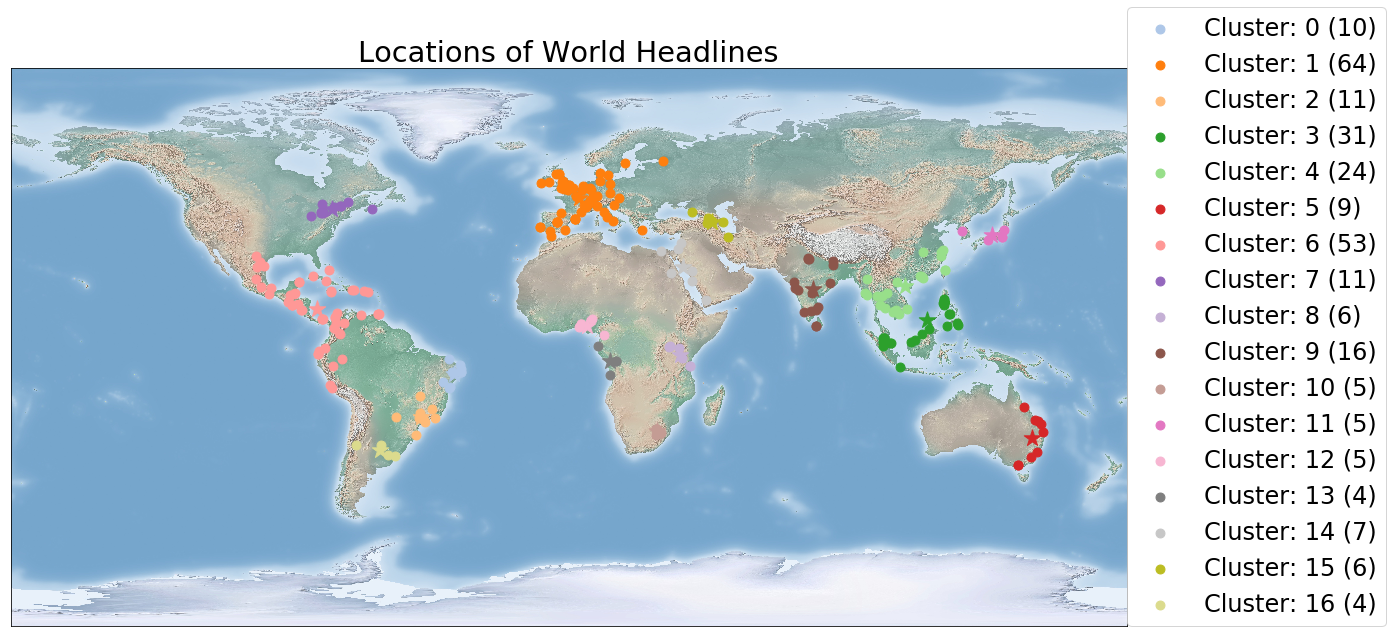

In [9]:
df_rdw_sorted = sort_cluster(df_rdw)

plotCluster(df_rdw_sorted, plotTitle="Locations of World Headlines")

In [10]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 130)
pd.set_option('display.max_colwidth', 100)

In [11]:
#############
##### 5 #####
#############

for i, cluster in df_us_sorted:
    print(f"\nCluster {i} top10 headlines: \n\n{cluster.nsmallest(10,'dist2center').headline}")


Cluster 0 top10 headlines: 

27                 Zika reported in Fort Pierce
22    More Zika patients reported in Fort Myers
19           Zika Spreads to Palm Beach Gardens
9                 Zika case reported in Jupiter
21      Zika symptoms spotted in Bonita Springs
15              Zika arrives in West Palm Beach
37       Zika symptoms spotted in Boynton Beach
36           Zika Troubles come to Delray Beach
20                             Zika in Tamarac!
24                   Zika arrives in Boca Raton
Name: headline, dtype: object

Cluster 1 top10 headlines: 

40                                      Philadelphia experts track pandemic
104                                     How to Avoid Hepatitis B in Trenton
93                           Princeton Encounters Severe Symptoms of Dengue
90                   Vineland authorities confirmed the spread of Chlamydia
108         More people in Allentown are infected with Chlamydia every year
109                                               

In [12]:
#############
##### 5 #####
#############

for i, cluster in df_rdw_sorted:
    print(f"\nCluster {i} top10 headlines: \n\n{cluster.nsmallest(10,'dist2center').headline}")


Cluster 0 top10 headlines: 

8       More Zika patients reported in Custodia
9                Zika case reported in Limoeiro
0       Mystery Virus Spreads in Recife, Brazil
7                        Zika spreads to Olinda
2    More Zika patients reported in Joao Pessoa
4                         Zika arrives in Natal
3       More Zika patients reported in Camacari
5                Zika case reported in Jacobina
1                    Zika spreading to Salvador
6            Zika symptoms spotted in Fortaleza
Name: headline, dtype: object

Cluster 1 top10 headlines: 

29    More Livestock in Fontainebleau are infected with Mad Cow Disease
12                              Scientists in Paris to look for answers
20                  Sick Livestock Leads to Serious Trouble for Belfort
71                                     Mad Cow Disease Detected in Lyon
53                               Mad Cow Disease Disastrous to Brussels
10                                Geneve Scientists Battle to Find Cur

In [13]:
# manually identified possible diseases
disease_cluster_us = {0:"Zika", 2:"Zika"}
disease_cluster_rdw = {0:"Zika", 1:"MCD", 2:"Zika", 3:"Zika", 4:"Zika", 6:"Zika", 9:"Zika"}

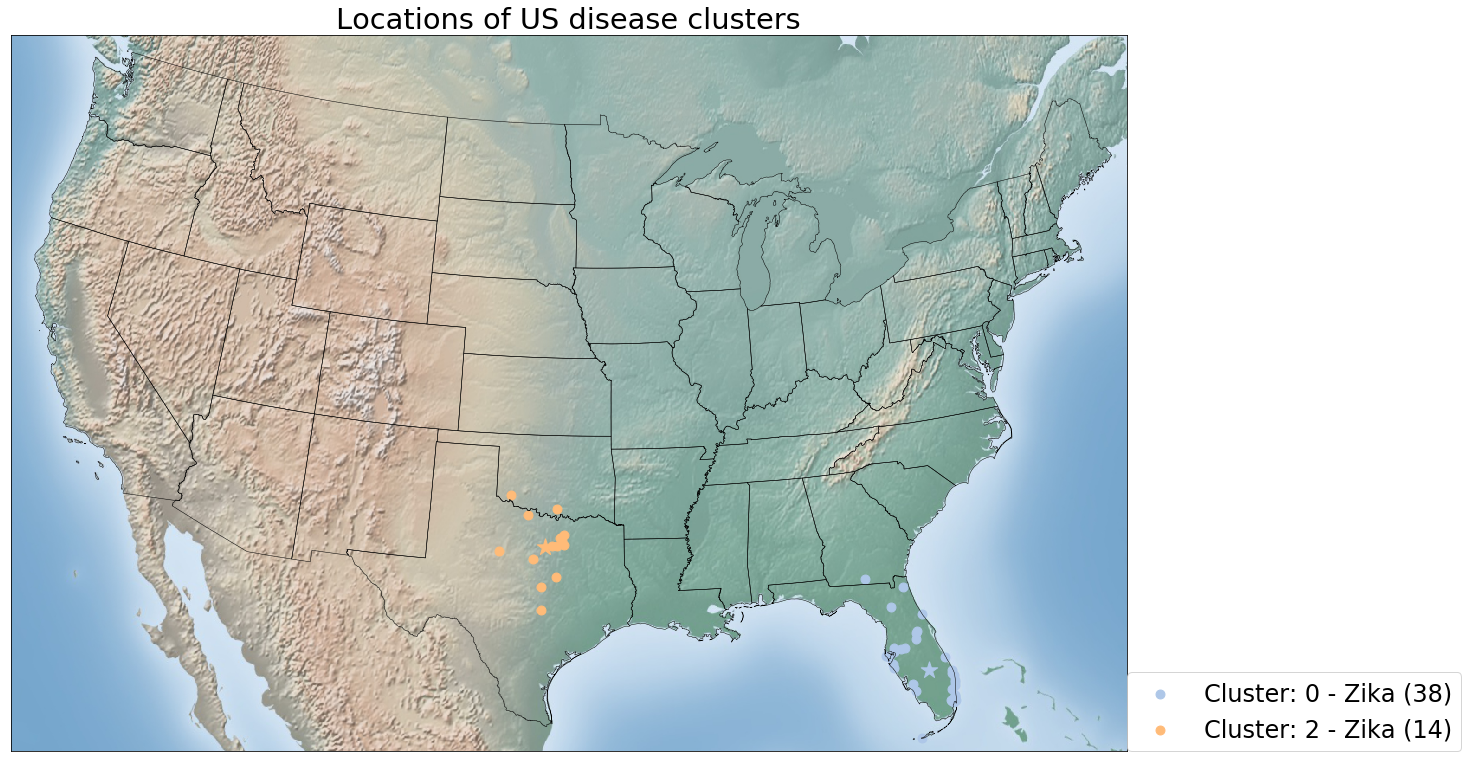

In [14]:
plotCluster(df_us[df_us["cluster"].isin(disease_cluster_us.keys())].groupby(["cluster"]), True, disease_cluster_us, plotTitle="Locations of US disease clusters")

In [15]:
df_us["disease"] = df_us['cluster'].map(disease_cluster_us)
df_us['disease'].value_counts()

Zika    52
Name: disease, dtype: int64

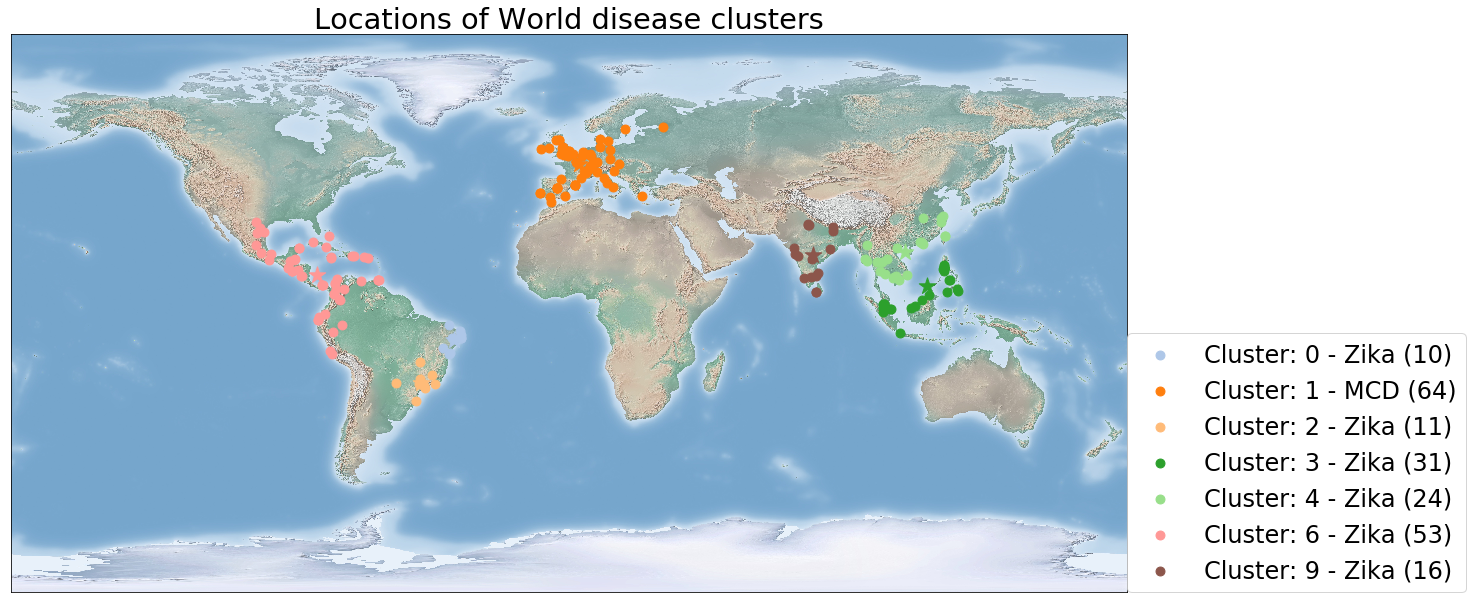

In [16]:
plotCluster(df_rdw[df_rdw["cluster"].isin(disease_cluster_rdw.keys())].groupby(["cluster"]), diseaseNames=disease_cluster_rdw, plotTitle="Locations of World disease clusters")

In [17]:
df_rdw["disease"] = df_rdw['cluster'].map(disease_cluster_rdw)
df_rdw['disease'].value_counts()

Zika    145
MCD      64
Name: disease, dtype: int64

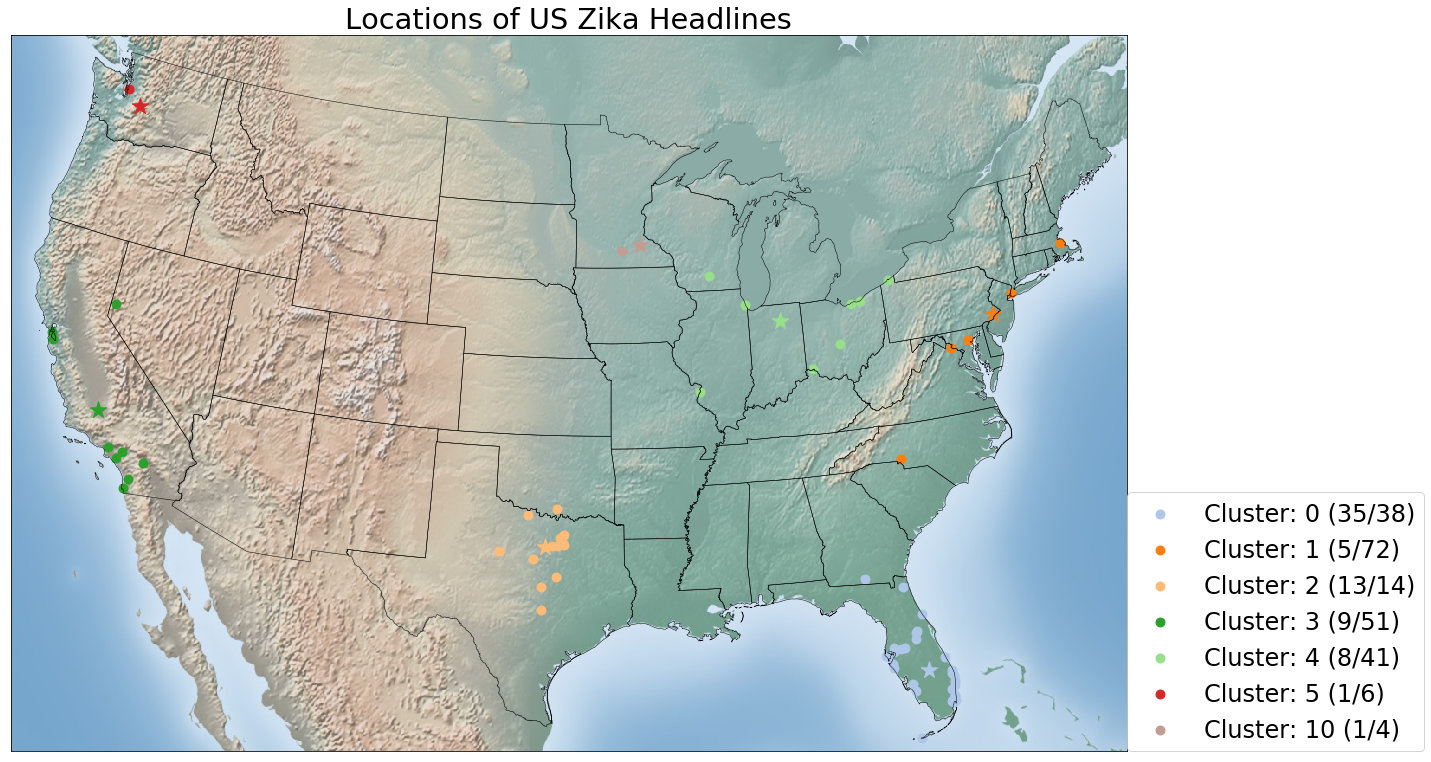

In [18]:
plotCluster(df_us[df_us["headline"].str.lower().str.contains('zika', na=False)].groupby(["cluster"]), us=True, countSize=True, plotTitle="Locations of US Zika Headlines")

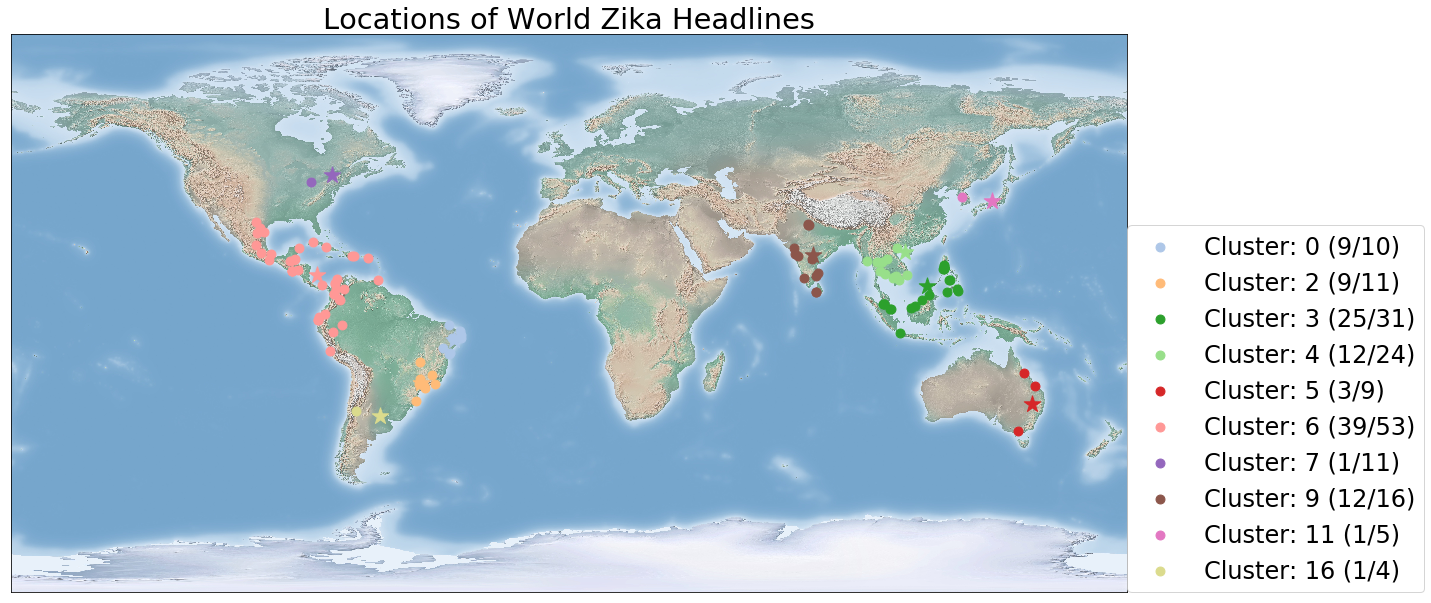

In [19]:
plotCluster(df_rdw[df_rdw["headline"].str.lower().str.contains('zika', na=False)].groupby(["cluster"]), countSize=True, plotTitle="Locations of World Zika Headlines")